In [1]:
'''
Cumulative test of RouteMap, BusModel, and TripDynamics.
'''

'\nCumulative test of RouteMap, BusModel, and TripDynamics.\n'

In [2]:
# General Imports
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [3]:
# Package Imports
import RouteMap as rm
import BusModel as bm
import TripDynamics as td
import Helper_Methods as hm

In [4]:
# Import the relevant area data:
# All Transit Stops:
stops_path = "./Data/Transit_Stops/Transit_Stops_for_King_County_Metro__transitstop_point.shp"
stops = gpd.read_file(stops_path)

# All signal lights:
signals_path = "./Data/Signals/KCM_Signals.shp"
signals = gpd.read_file(signals_path)

# All Streets:
seattle_streets_data ="./Data/Seattle_Streets/KCM_Streets.shp"
seattle_streets = gpd.read_file(seattle_streets_data)

In [5]:
# make a duplicate of the stops
all_stops = stops.copy()

# make a series of the signal geometry
all_signals = signals['geometry'].reset_index(drop=True)

# get the speed limits of all streets in the dataset
limits = seattle_streets[['geometry', 'SPEED_LIM']]

In [6]:
# set the route number, number of samples of points
# and time period of interest
route = 101
concat_val = 6
period = 'AM'

# Import the route data
route_path = "./Data/Routes/Individual_Routes/rt{}_pts.shp".format(route)
route_raw = gpd.read_file(route_path)

# filter to the resolution of the concat value
route_concat = route_raw[::concat_val]
route_concat = route_concat.reset_index(drop=True)

# get a series of the geometry and elevation from the data
route_geometry = route_concat['geometry']
route_elevation = route_concat['Z']

# using the helper method get_stops, find all stops the route intersects with.
route_stops = hm.get_stops(all_stops, str(route))['geometry'].reset_index(drop=True)

In [ ]:
# Generate a RouteMap with the RouteMap module, passing 
# the route geometry, elevation, limits, route_stops, 
# signals.
route_test_map = rm.RouteMap(route_geometry,
                             route_elevation,
                             limits,
                             route_stops,
                             all_signals,
                             debug = True)


#save the route_map as a csv for future, faster, use. 
route_test_map.get_gdf().to_csv('./Data/SAVED_ROUTEMAPS/route_map_{}.csv'.format(route))

In [7]:
# Load the RouteMap from the CSV
# First, generate a routemap from the geometry and elevation
route_test_map = rm.RouteMap(route_geometry, route_elevation)

# Add in the details from the saved CSV
route_test_map = route_test_map.load_from_gdf('./Data/SAVED_ROUTEMAPS/route_map_{}.csv'.format(route))

In [8]:
# Use in-built methods in RouteMap to get a smoothed elevation
# as a pandas series
smoothed_test_elevation = route_test_map.smooth_elevation()

# set the smoothed elevation as the route_test_map's elevation
smoothed_test_map = route_test_map.set_elevation(smoothed_test_elevation)


# convert distances using elevation to true distances traveled:
p_dist_elev = route_test_map.calc_travel_distances()
route_test_map = route_test_map.set_point_distances(p_dist_elev)

<Axes: >

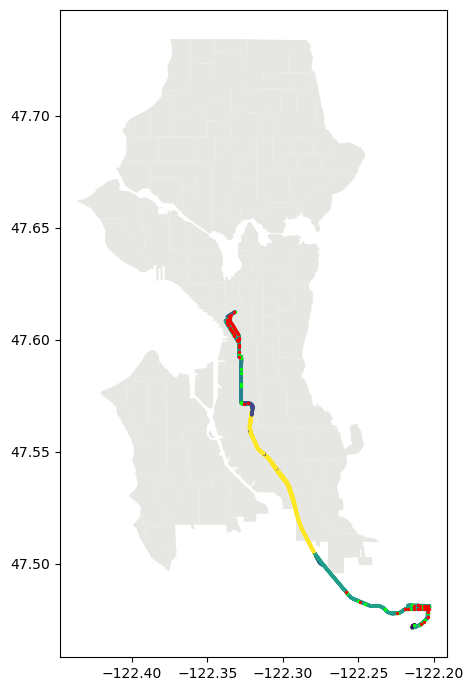

In [9]:
# Display a map of the route overlayed over area data:
# Import area map:
seattle = gpd.read_file("./Data/Census_Tracts_2000/Census_Tracts_2000.shp")

# filter out all 'water' zones in the data for clarity
seattle = seattle[(seattle['WATER'] != 1)]

# set up a figure:
fig, ax = plt.subplots(1, figsize = (5,10))

# Plot the map of the area:
seattle.plot(color="#E6E6E3", ax=ax, zorder = 0)

# get the geodtaframe of the route_map
smooth_route_gdf = smoothed_test_map.get_gdf()

# plot the route by speed limit individually
smooth_route_gdf.plot(column='speed_limit[km/s]',
                      markersize=2,
                      ax=ax,
                      alpha=1,
                      zorder=10)


# plot the stops and signals
smooth_route_gdf[smooth_route_gdf['is_stop'] == True].plot(color='lime',
                                                           markersize=2,
                                                           ax=ax,
                                                           zorder=15)
smooth_route_gdf[smooth_route_gdf['is_signal'] == True].plot(color='red',
                                                             markersize=2,
                                                             ax=ax,
                                                             zorder=20)
                                                             


In [10]:
# Creating a bus model:
# Import an acceleration profile
acc_prof_path = "./Data/Accel_Prof/acceleration.csv"
raw_acc_prof = pd.read_csv(acc_prof_path, names=['time[s]', 'accel.[g]'])

# Make a duplicate to alter
a_prof = raw_acc_prof.copy()

# Convert g's to m/s^2 and then drop g's
a_prof['accel.[m/s^2]'] = a_prof['accel.[g]'] * 9.81
a_prof = a_prof.drop(columns = ['accel.[g]'])

# Create a default bus with the acceleration profile from above,
# otherwise using the default parameters
default_bus = bm.BusModel(a_prof)

In [11]:
# Creating a trip:
# Load the ridership data
ridership_path = "./Data/Trip_Data/Zon183Unsum.csv"
kcm_ridership = pd.read_csv(ridership_path)

# filter the ridership to the selected period and route
trip_ridership = kcm_ridership[(kcm_ridership['Route']==route) & (kcm_ridership['Period']==period)]

# sort the route_ridership so the stops are in proper order
sorted_riders = trip_ridership.sort_values(by=['InOut','Trip_ID', 'STOP_SEQ', 'STOP_ID'])
sorted_riders = sorted_riders[['InOut','STOP_SEQ', 'STOP_ID', 'AveOn', 'AveOff', 'AveLd']]
sorted_riders = sorted_riders.drop_duplicates(subset=['InOut','STOP_SEQ'], keep='first')
sorted_riders = sorted_riders.drop_duplicates(subset='STOP_ID', keep='first')
sorted_riders = sorted_riders.reset_index(drop = True)
sorted_riders['Index'] = sorted_riders.index

# get the mean ridership change at each stop
sorted_riders_diff = sorted_riders['AveOn'] - sorted_riders['AveOff']

#Export the rider difference to a csv for ease of editing and access
#sorted_riders_diff.to_csv('rider_diff_{}.csv'.format(route))
#sorted_riders_diff = pd.read_csv('./Data/Testing_materials/test_diff_22.csv')['0']
sorted_riders_diff = sorted_riders_diff[:len(smooth_route_gdf[smooth_route_gdf['is_stop'] == True])]

In [12]:
import pandas as pd
import numpy as np

class BusModel:
    def __init__(self,
                 acceleration_profile, # two column dataframe containing time(s), accel(m/s^2)
                 raw_mass = 13041, # kilograms, New Flyer Xcelsior Charge []
                 bus_width = 2.6, # meters, New Flyer Xcelsior Charge []
                 bus_height = 3.3, # meters, New Flyer Xcelsior Charge []
                 drag_coeff = 0.6, # From Aggregate, Abdelaty & Mohamed []
                 factor = 1.1, # intertial factor, Asamer Et. Al []
                 fric_coeff = .01, # Abdelaty & Mohamed []
                 motor_eff = .916, # unknown source, not listed in paper -- tourque and speed depemdamt, next level would be based on tourqe
                 invert_eff = .971, # unknown source, not listed in paper
                 max_power = 160, # kW, output New Flyer Xcelsior Charge []
                 regen = .6, # Gallet et al []
                 eff_aux = .89, # unknown source, Auxulliary system efficiency?
                 aux_load = 7000, # W, Abdelaty & Mohamed []
                 a_braking = -1.5, #m/s^2 # https://www.apta.com/wp-content/uploads/APTA-BTS-BC-RP-001-05_Rev1.pdf <-- Possible source, handbrake road minimum is ~1.5
                 final_a = .4, # m/s^2, defualt acceleration after profile finishes
                 max_velocity = 26.8224, # m/s, = 60 mph
                 maintain_acceleration = False, # boolean for if bus should maintain the last a in 
                                                # profile or use final_a for extrapolating new vals
                 num_starting_passengers = 0,
                 pass_ave_mass = 80, #kg, Gallet et Al. []
                
                 ):
        # raw bus characteristics -- Not all of these are used, but may be useful for the future
        self._empty_mass = raw_mass
        self._bus_width = bus_width
        self._bus_height = bus_height
        self._bus_front_area = self._bus_width * self._bus_height
        self._drag_coeff = drag_coeff
        self._i_factor = factor
        self._fric_coeff = fric_coeff
        self._motor_eff = motor_eff
        self._invert_eff = invert_eff
        self._max_power = max_power
        self._regen = regen
        self._eff_aux = eff_aux
        self._aux_load = aux_load
        
        # driving model characteristics
        self._a_braking = a_braking
        self._final_a = final_a
        self._final_a_boolean = maintain_acceleration
        self._max_v = max_velocity
        self._accel_profile_df = self.interpret_accel_prof(acceleration_profile)
        
        # variables based on position in route
        self._passengers = num_starting_passengers
        self._mass_p_pass = pass_ave_mass
        self._current_velocity = 0
        self._current_accel = 0
        self._distance_traveled = 0
        self._bus_status = "Stopped"
        self._current_mass = self._empty_mass + self._passengers * self._mass_p_pass
        
        
    def interpret_accel_prof(self, accel_prof):
        """
        interpret_accel_prof is used to format the acceleration
        profile so as to have velocity and distance traveled.
        
        Parameters:
        accel_prof: dataframe of time and acceleration values,
                    in seconds and m/s^2.
        
        Returns: 
        dataframe of time, acceleration, velocity, and distance
        in seconds and meters units.
        """
        # Generate a copy of the profile
        acc_prof = accel_prof.copy()
        
        # Get the changes in time
        acc_prof['dt'] = acc_prof['time[s]'].diff()
        
        # use mean_integral to get the velocity data
        acc_prof['vel.[m/s]'] = self.mean_integral(acc_prof['dt'], acc_prof['accel.[m/s^2]'])
        
        # use mean_integral to get the distance data
        acc_prof['dist.[m]'] = self.mean_integral(acc_prof['dt'], acc_prof['vel.[m/s]'])
        
        while (not (acc_prof['vel.[m/s]'].iloc[-1] >= self._max_v)):
            
            # Generate a new row dictionary from the columns
            new_row = dict.fromkeys(list(acc_prof.columns))
            
            # set the step time to be 1 second
            d_t = 1
            
            # calculate the next time point using the previous and dt
            next_time = acc_prof['time[s]'].iloc[-1] + d_t 
            
            # default to using the _final_a acceleration
            next_accel = self._final_a
            
            # if the parameters say to maintain acceleration,
            if self._final_a_boolean:
                # Keep the last acceleration
                next_accel = acc_prof['accel.[m/s^2]'].iloc[-1]
            
            # calculate the next velocity
            next_v = acc_prof['vel.[m/s]'].iloc[-1] + d_t*next_accel
            
            # calculate the next distance
            next_d = acc_prof['dist.[m]'].iloc[-1] + d_t * (next_v + acc_prof['vel.[m/s]'].iloc[-1]) / 2
            
            # generate the list of data
            data = [next_time, next_accel, d_t, next_v, next_d]
            
            # put the data into the dictionary
            for i in range(len(data)): new_row[list(new_row.keys())[i]] = data[i]
            
            # Append the new row on to the profile dataframe
            acc_prof.loc[len(acc_prof)] = new_row
            
        # drop the dt column
        #acc_prof = acc_prof.drop(columns = ['dt'])
        
        # return the acceleration profile dataframe
        return acc_prof
    
    
    def mean_integral(self, time_changes, value_series):
        """
        mean_integral takes in a series of dt (s) values, and
        a corresponding series of other values to be integrated
        with respect to time, and provides the result as a
        cumulative summing series. 

        Parameters:
        time_changes: a pandas series of dT values in units of seconds
        value_series: a pandas series of d[value] that has relation to time.

        Returns: 
        a pandas series of the integrated values.
        """
        int_prof = pd.DataFrame()
        int_prof['mean_val_btw'] = value_series.rolling(window=2).mean()
        int_prof['d[value]'] = int_prof['mean_val_btw'] * time_changes
        int_prof['integrated'] = int_prof['d[value]'].cumsum()

        return int_prof['integrated'].fillna(0)
    
    
    def get_accel_profile(self):
        return self._accel_profile_df
    
    
    def velocity(self):
        return self._current_velocity
    
    
    def set_v(self, v):
        self._current_velocity = v
    
    
    def max_velocity(self):
        return self._max_v
    
    
    def get_braking_distance(self, velocity, braking_factor, ext_acc):
        '''
        get_braking_distance() takes in a velocity and the current external accelerations,
        and provides a calculation as to how far the bus would have to brake to reach a velocity of zero.
        
        Parameters:
        velocity: velocity, in m/s, the bus is travelling at
        ext_acc: the external accelerative force in m/s^2 the bus is experiencing.
        
        Returns:
        a distance, in meters, of how far the bus would have to brake to reach a velocity of zero.
        '''
        
        
        wind_accel = self.get_aerodynamic_drag(velocity, 0, 1.2)
        
        # Combine to get the net acceleration on the bus
        net_accel = -wind_accel - ext_acc
        a_bus = net_accel + self._a_braking*braking_factor*self._i_factor
        
        # Using the kinematics equation vf^2 = vi^2 + 2a(dX) to get
        # braking distance
        return round((-velocity**2 / (2*(a_bus))), 5) # Convert to meters

    
    def get_aerodynamic_drag(self, bus_speed, wind_speed, air_density):
        '''
        get_aerodynamic_drag takes in wind speed and air density, and returns
        the acceleration, in m/s^2, they provide.
        
        Parameters:
        wind_speed: velocity, in m/s, of the wind.
        air_density: density, in kg/m^3, of the air.
        
        Returns:
        aerodynamic acceleration, in m/s^2.
        '''
        # Using the drag coefficient, bus frontal area, and passed parameters, calculate the acceleration of air due to drag
        air_drag = (self._drag_coeff * self._bus_front_area * (air_density/2) * (bus_speed - wind_speed)**2)/self._current_mass
        
        # Return said value.
        return air_drag # acceleration of air drag
    
    
    def get_inertial_acceleration(self):
        '''
        get_inertial_acceleration calculates the current acceleration of intertia the bus is undergoing.
        
        Parameters:
        N/A
        
        Returns:
        inertial acceleration of the bus, in Newtons.
        
        '''
        
        # Use the intertial factor, current mass, and current acceleration,
        # to get inertial acceleration.
        inertia = (self._i_factor * self._current_mass * self._current_accel) / self._current_mass
        return inertia # acceleration of inertia
    
    
    def update_riders(self, val, cat='change'):
        '''
        update riders takes in a value of how many riders get on (positive),
        or disembark (negative), and affects the bus mass and passenger count of the bus.
        
        Parameters:
        val: change in passengers as a float.
        cat: string, either 'change' or 'set', depending on if the number of passengers
             is being changed, or set. Default is 'change'.
        '''
        # Update passenger number, sum should never be < 0
        if (cat=='change'):
            self._passengers = self._passengers + val
        elif (cat == 'set'):
            self._passengers = val
        
        # Update total mass
        self._current_mass = self._empty_mass + self._passengers * self._mass_p_pass
        return None
    
    
    # Getter methods
    def update_mass(self, val):
        self._current_mass = val
        return None
    
    def get_n_riders(self):
        return self._passengers
    
    def get_mass(self):
        return self._current_mass
    
    def get_acceleration(self):
        return self._current_accel
    
    def get_fric_coeff(self):
        return self._fric_coeff

    def get_b_accel(self):
        return self._a_braking
    
    def get_motor_eff(self):
        return self._motor_eff
    
    def get_invert_eff(self):
        return self._invert_eff
    
    def get_auxill_efficiency(self):
        return self._eff_aux
    
    def get_aux_load(self):
        return self._aux_load
    
    def get_regen_eff(self):
        return self._regen

    
    def accelerate_v4(self, dist, ext_acc):

            # Get acceleration profile
            prof = self.get_accel_profile().copy()

            # get current mass and velocity
            mass = self._current_mass
            vel = self._current_velocity

            # set a variable for the route acceleration
            route_accel = ext_acc

            # get the acceleration of drag, with wind speed of 0 and air density of
            # 1.2 kg/m^3, to be adjustible later
            wind_accel = prof.apply(lambda x: self.get_aerodynamic_drag(x['vel.[m/s]'], 0, 1.2), axis=1)

            # calculate the true acceleration needed to reach the target acceleration
            net_acc_for_target = prof['accel.[m/s^2]']*self._i_factor + wind_accel + route_accel

            # calculate the net power needed for each step in kW
            power_est = net_acc_for_target*mass*prof['vel.[m/s]']/1000

            # Upper and lower limits of motor output
            power_est = power_est.where(power_est < 160, 160)
            power_est = power_est.where(power_est > 0, 0)

            # If a value is lower than 100 watts, set it to zero, then replace with
            # the second lowest power output in the profile. This is being done to
            # avoid weird jagged motions and what could be considered noise.
            power_est[power_est < .1] = 0
            sorted(list(power_est.unique()))
            power_est[power_est == 0] = sorted(list(power_est.unique()))[0]

            #limit the acceleration by power limiter (read, true acceleration of motor)
            limited_acceleration = power_est*1000/mass/prof['vel.[m/s]']

            # convert the limited_acceleration back to true acceleration by removing externalities
            net_acc = (limited_acceleration - wind_accel - route_accel)/self._i_factor

            # get the true bus velocities, swap nan for zero
            net_vel = (net_acc*prof['dt']).cumsum()
            net_vel = net_vel.fillna(0)

            # get the travel distances 
            net_dist = (net_vel*prof['dt']).cumsum()
            net_dist = net_dist.fillna(0)

            # Get the closest index to the current velocity
            v_closest_index = list((net_vel-vel).abs().argsort())[0]

            # set the closest index of velocity as the basis for dist=0
            net_dist = net_dist - net_dist[v_closest_index]

            # find the distance index closest to travel distance
            d_closest_index = list((net_dist-dist).abs().argsort())[0]

            # get final velocity, set to bus velocity
            self._current_velocity = net_vel[d_closest_index]

            # get final acc, set to bus acc
            self._current_accel = net_acc[d_closest_index]

            # get mean power used:
            mean_power = power_est[v_closest_index:d_closest_index+1].mean()

            # get elapsed time
            dt = prof['dt'][v_closest_index:d_closest_index+1].sum()

            return mean_power*1000, dt

    def brake_v3(self, dist, braking_factor, ext_acc):
        '''
        brake_v3() takes in a distance and braking factor and external acceleration,
        and determines the power and elapsed time for the bus to
        experience those conditions.
        '''

        # Get the current velocity and braking acceleration, 
        # using the factor to help determine how intense the braking is.
        v0 = self._current_velocity
        braking_acc = self._a_braking*braking_factor*self._i_factor

        # determine the external accelerations from intrinsic bus factors
        route_accel = ext_acc
        wind_accel = self.get_aerodynamic_drag(v0, 0, 1.2)

        # Generate the net acceleration the bus is experiencing, a_bus
        net_accel = (- wind_accel - route_accel)
        a_bus = net_accel + braking_acc

        vf = 0
        # use kinematic equation to calculate final velocity,
        # Check to ensure calc is possible.
        if (v0**2 > np.abs(2*a_bus*dist)):
            vf = np.sqrt(v0**2 + 2*a_bus*dist)
            # if final velocity is slower than .1 m/s, set it to be zero
            if (vf < .1):
                vf = 0
        else:
            vf = 0


        #get the change in time from kinematics equations
        dt = ((vf - v0)/a_bus)

        # Calculate the power of the braking
        power_calc = braking_acc*self._current_mass*dist/dt

        #Set the velocity and acceleration of the bus.
        self._current_velocity = vf
        self._current_acceleration = a_bus

        # return the power and elapsed time.
        return power_calc, dt
        
    def maintain_v4(self, dist, ext_acc):
        '''
        maintain_v4() takes in distance traveled and the external 
        accelerational forces, and calculates the power needed to
        maintain the current velocity and the elapsed time.
        
        Parameters:
        dist: distance of travel in meters as a float.
        ext_acc: external accelerative force the bus is currently experiencing.
        
        Returns:
        a touple containing the power [W] used and the elapsed time [s]. 
        '''
        
        # Get the variables that are input into the equations,
        # acceleration, velocity, and mass
        route_accel = ext_acc
        v1 = self._current_velocity
        a_bus = self._current_accel
        cur_mass = self._current_mass
        
        
        # Assuming that the change in velocity has negligible affect on wind acceleration
        wind_accel = self.get_aerodynamic_drag(v1, 0, 1.2)
        
        # Get the change in time
        dt = dist/v1
        
        # Get the acceleration needed to match externalities,
        # and the corresponding power.
        out_accel = (route_accel + wind_accel)*self._i_factor
        initial_power = cur_mass * out_accel * dist / dt
        
        # Set a dummy variable for the power calculation
        power_calc = 0
        
        # If the initial power calculation exceeds the limit, 
        if (initial_power > 160000):
            
            # Set up a dummy iterator
            i=0
            
            # Set up a variable for final velocity
            vf = v1
            
            # Set up a variable to hold the power
            temp_power = initial_power
            
            # Set up a dummy variable for acceleration
            temp_accel = 0
            
            # Loop until the temporary power is lower than the limit
            while (temp_power > 160000):
                
                # Iterate
                i+=1
                
                # de-incriment acceleration the bus outputs
                temp_accel = out_accel - .000001*i
                
                # find the new velocity
                vf = np.sqrt(v1**2 + 2*.000001*i*dist)
                
                # Find the new change in time
                dt = (vf - v1) / .000001*i
                
                # Find the new power
                temp_power = cur_mass * temp_accel * dist / dt
            
            # Set the new power, velocity, and acceleration
            power_calc = temp_power
            self._current_velocity = vf
            self._current_acceleration =  - .000001*i
            
        #Otherwise, just use the initial power calculation and time
        else:
            self._current_velocity = v1
            self._current_acceleration = 0
            power_calc = initial_power

        return power_calc, dt

In [13]:
mass_array = [10, 100, 1000, 10000, 100000] #5
velocity_array = [0, 1, 2, 10, 20, 100] #6
grade_array = [-20, -17, -9, 0, 9, 17, 20] #7
braking_factors = [1, .8, .6, .4, .2] #5

In [52]:
'''
Testing get_braking_distance - compare different parameters, if nothing prints, then it's a victory!
'''

def braking_distance_formula(v_i, m, grade, braking_factor):
    a_fric = (.01)*9.81*np.cos(np.arctan(grade/100))
    a_hill = 9.81*np.sin(np.arctan(grade/100))
    a_brake = 1.1*-1.5*braking_factor
    a_wind = .6*8.58*1.2*(v_i**2)/(2*m)
    d = -(v_i**2)/2 * (1/(a_brake - a_wind - a_hill - a_fric))
    return d

def bus_bd(v_i, m, grade, braking_factor):
    sample_bus = BusModel(a_prof, raw_mass = m)
    ext_a = (.01)*9.81*np.cos(np.arctan(grade/100)) + 9.81*np.sin(np.arctan(grade/100))
    sample_bus.set_v(v_i)
    return sample_bus.get_braking_distance(sample_bus.velocity(), braking_factor, ext_a)

for mass in mass_array:
    for velocity in velocity_array:
        for grade in grade_array:
            for bf in braking_factors: 
                dist = braking_distance_formula(velocity, mass, grade, bf)
                dist_bus = bus_bd(velocity, mass, grade, bf)
                diff = abs(dist-dist_bus)
                if (diff > .05):
                    print(diff, velocity, mass, grade, bf)
#4/18 - Nothing printed, so we're good with all of those methods!


KeyboardInterrupt



In [74]:
'''
Testing acceleration

 --- Acceleration profile, integrated from bus method. ---

      time[s]  accel.[m/s^2]        dt  vel.[m/s]    dist.[m]
0    0.000000        0.00545       NaN   0.000000    0.000000
1    0.917431        1.13360  0.917431   0.522500    0.239679
2    1.972477        1.21535  1.055046   1.761625    1.444607
3    2.935780        1.23715  0.963303   2.942875    3.710536
4    4.036697        1.23170  1.100917   4.301875    7.698472
5    5.000000        1.19355  0.963303   5.470000   12.405109
6    6.055046        1.12270  1.055046   6.691875   18.820777
7    7.018349        1.05730  0.963303   7.741875   25.772813
8    8.027523        0.97555  1.009174   8.767625   34.103294
9    8.990826        0.90470  0.963303   9.673250   42.985367
10  10.000000        0.83930  1.009174  10.553250   53.191399
11  11.055046        0.77935  1.055046  11.407125   64.776001
12  12.018349        0.73575  0.963303  12.136875   76.116001
13  13.027523        0.67580  1.009174  12.849125   88.723615
14  14.036697        0.63765  1.009174  13.511875  102.025037
15  15.045872        0.59405  1.009174  14.133375  115.974475
16  16.009174        0.56135  0.963303  14.689875  129.857233
17  17.018349        0.53955  1.009174  15.245375  144.962176
18  18.027523        0.52320  1.009174  15.781625  160.618002
19  19.036697        0.50140  1.009174  16.298625  176.805284
20  19.954128        0.49050  0.917431  16.753625  191.966867
21  21.009174        0.47960  1.055046  17.265375  209.912669
22  22.018349        0.46325  1.009174  17.741125  227.576500
23  23.027523        0.44690  1.009174  18.200375  245.712119
24  24.036697        0.43055  1.009174  18.643125  264.302876
25  25.045872        0.41965  1.009174  19.072125  283.333506
26  26.009174        0.39785  0.963303  19.465875  301.895387
27  27.018349        0.38695  1.009174  19.861875  321.739665
28  28.073394        0.37060  1.055046  20.261500  342.905665
29  28.990826        0.34335  0.917431  20.589000  361.644427
30  29.954128        0.33790  0.963303  20.917125  381.635909
31  30.954128        0.40000  1.000000  21.317125  402.753034
32  31.954128        0.40000  1.000000  21.717125  424.270159
33  32.954128        0.40000  1.000000  22.117125  446.187284
34  33.954128        0.40000  1.000000  22.517125  468.504409
35  34.954128        0.40000  1.000000  22.917125  491.221534
36  35.954128        0.40000  1.000000  23.317125  514.338659
37  36.954128        0.40000  1.000000  23.717125  537.855784
38  37.954128        0.40000  1.000000  24.117125  561.772909
39  38.954128        0.40000  1.000000  24.517125  586.090034
40  39.954128        0.40000  1.000000  24.917125  610.807159
41  40.954128        0.40000  1.000000  25.317125  635.924284
42  41.954128        0.40000  1.000000  25.717125  661.441409
43  42.954128        0.40000  1.000000  26.117125  687.358534
44  43.954128        0.40000  1.000000  26.517125  713.675659
45  44.954128        0.40000  1.000000  26.917125  740.392784

'''

mass = 13041

# Compare time and power differences between straight-shots and stepwise-----
print("Comparing dt and power calculations at different grades for straight-shots and stepwise:")
print()

for grade in grade_array:
    ext_a = (.01)*9.81*np.cos(np.arctan(grade/100)) + 9.81*np.sin(np.arctan(grade/100))
    dist = 10
    sample_bus = BusModel(a_prof)
    p_tot = 0
    t_tot = 0
    for i in range(10):
        d_tot += 10
        p, t = sample_bus.accelerate_v4(dist, ext_a)
        p_tot += p
        t_tot += t

    sample_bus = BusModel(a_prof)
    p_2, t_2 = sample_bus.accelerate_v4(dist*10, ext_a)
    tdif = t_2 - t_tot
    pdif = p_2- p_tot
    print("grade: {}, t_diff: {}, p_diff: {}".format(grade,tdif,pdif))
    
print()

Comparing dt and power calculations at different grades for straight-shots and stepwise:

grade: -20, t_diff: -11.100917425999995, p_diff: 0.0
grade: -17, t_diff: -10.917431194999995, p_diff: 0.0
grade: -9, t_diff: -10.137614680999999, p_diff: -203863.7558613273
grade: 0, t_diff: -10.137614680999999, p_diff: -1162612.332104844
grade: 9, t_diff: -7.155963311000001, p_diff: -1358243.5077149784
grade: 17, t_diff: -12.201834854999998, p_diff: nan
grade: 20, t_diff: -19.770642191999983, p_diff: nan



In [64]:
!pip install line_profiler

   ---------------------------------------- 0.0/123.2 kB ? eta -:--:--
   ------------ -------------------------- 41.0/123.2 kB 991.0 kB/s eta 0:00:01
   ---------------------------------------  122.9/123.2 kB 1.4 MB/s eta 0:00:01
   ---------------------------------------- 123.2/123.2 kB 1.0 MB/s eta 0:00:00


In [71]:

import line_profiler as lprof
profiler = lprof.LineProfiler()



'''
If the bus accelerates:
starting velocity = 0
mass = 13000
external_acceleration = .098 -- flat
acceleration distance = 20 meters
wind acceleration = 0

the bus needs to accelerate by 0.00545 + .098 + 0 to reach the target goal of .00545
and then by 1.133*1.1 + .098 + 0 to reach the next target of 1.133. 
so, what we can take this to mean is a_prof + a_ext + a_wind = a_true.

In other words, the force the bus wants to perform is 70.8 N in the direction of travel, but will need  70.8*1.1 + 1274 + 0

so the true acceleration of the bus at point 1 will be .1, 
                                       point 2 will be 1.3443
                                       point 3 will be 1.435, ad astra.

to get the true power of the bus, we multiply the true acceleration by the mass and corresponding velocity.

Then, we take that and sum them by each point per. 
'''

def generate_power_frame(m, grade, dist):
    a_fric = (.01)*9.81*np.cos(np.arctan(grade/100))
    a_hill = 9.81*np.sin(np.arctan(grade/100))
    acc_prof = a_prof.copy()
    profile_length = len(acc_prof)
    
    
    acc_prof=acc_prof.rename(columns = {'accel.[m/s^2]':'true_accel'})
    acc_prof['t_i'] = acc_prof['time[s]']
    del(acc_prof['time[s]'])
    acc_prof['t_f'] = acc_prof['t_i'].shift(-1)
    acc_prof['dt'] = (acc_prof['t_f'] - acc_prof['t_i']) 
    del(acc_prof['t_i'])
    del(acc_prof['t_f'])
    acc_prof['vi'] = 0
    acc_prof['power'] = 0
    acc_prof['a_param'] = 0
    trav_dist = 0
    i = 0
    
    # This could be written more efficiently but it works for now. This loop specifically is the drag.
    while (i<profile_length):
        tr_acc = acc_prof['true_accel'][i]
        dt = acc_prof['dt'][i]
        vi = acc_prof['vi'][i]
        wind_acc = .6*8.58*1.2*(vi**2)/(2*m)
        P = get_power(tr_acc,dt,vi,m,a_hill+a_fric+wind_acc,1.1)
        
        if P > 160000:
            tr_acc = get_max_accel(160000, dt, vi, m, a_hill+a_fric+wind_acc, 1.1)
            P = get_power(tr_acc,
              dt,
              vi,
              m,
              a_hill+a_fric+wind_acc,
              1.1)
            
        # set the column varaibles to the adjustments
        vi += tr_acc * dt
        dx = vi*dt
        
        trav_dist += dx

        acc_prof.at[i+1,'vi'] = vi
        acc_prof.at[i, 'true_accel'] = tr_acc
        acc_prof.at[i, 'power']= P
        acc_prof.at[i, 'dt'] = dt
        acc_prof.at[i, 'a_param'] = (a_hill+a_fric+wind_acc)
        i+=1

    acc_prof.drop(acc_prof.tail(2).index,inplace=True)
    return acc_prof   
        
def get_power(a_true, dt, vi, m, a_out, i_factor):
    P = m * (a_out + i_factor * a_true) * ((2 * vi + dt * a_true) / (2))
    return P
                
                
def get_max_accel(pmax, dt, vi, m, a_out, i_factor):
    sub1 = (4*(i_factor*dt)*((2*pmax/m) - 2*a_out*vi) + (-a_out * dt - 2*vi*i_factor)**2)
    num = (sub1)**(1/2) - (a_out * dt) - (2 * vi * i_factor)
    denom = 2 * i_factor * dt
    
    acc = num/denom
    
    if acc < 0:
        acc = -acc
    
    return acc


accelerate_v5(13041, -20, 20.762709251605855, 14)

profiled_func = profiler(accelerate_v5)
profiled_func(13041, -20, 20.762709251605855, 14) 
profiler.print_stats()

Timer unit: 1e-07 s

Total time: 0.0701057 s

Could not find file C:\Users\Sebastian\AppData\Local\Temp\ipykernel_15440\2863393141.py
Are you sure you are running this program from the same directory
that you ran the profiler from?
Continuing without the function's contents.

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           
     2         1     632254.0 632254.0     90.2  
     3         1        117.0    117.0      0.0  
     4         1       3378.0   3378.0      0.5  
     5         1         12.0     12.0      0.0  
     6         1          7.0      7.0      0.0  
     7         1          9.0      9.0      0.0  
     8         1          8.0      8.0      0.0  
     9         1          8.0      8.0      0.0  
    10         1          8.0      8.0      0.0  
    11         2         25.0     12.5      0.0  
    12         1         13.0     13.0      0.0  
    13                                           
    14    

In [72]:
def accelerate_v5(m, grade, v_i, dist):
    power_frame = generate_power_frame(m, grade, dist)
    power_frame_len = len(power_frame)
    profile_max = list(power_frame['vi'])[-1]
    trimmed_frame = 0
    trav_dist = 0
    p_list = []
    dt_list = []
    cur_v = v_i
    i=0
    while (dist > trav_dist):
        if (cur_v < profile_max):
            v_closest_index = list((power_frame['vi']-cur_v).abs().argsort())[0]
            p = power_frame['power'][v_closest_index]
            dt = power_frame['dt'][v_closest_index]
            a = power_frame['true_accel'][v_closest_index]
            outside_a = power_frame['a_param'][v_closest_index]
            cur_v += dt*a
            dx = cur_v*dt
            # Check if this would go over the distance
            if dx > abs(trav_dist - dist):
                dx = abs(trav_dist - dist)
                cur_v -= a * dt 
                dt = dx * (1.1 * a + outside_a) * m / p
                cur_v += a * dt
            trav_dist += dx
            p_list.append(p)
            dt_list.append(dt)
            
        else:
            p = list(power_frame['power'])[-2]
            dt = list(power_frame['dt'])[-2]
            a = list(power_frame['true_accel'])[-1]
            outside_a = (.01)*9.81*np.cos(np.arctan(grade/100)) + 9.81*np.sin(np.arctan(grade/100)) + .6*8.58*1.2*(cur_v**2)/(2*m)
            cur_v += dt*a
            dx = cur_v*dt
            # Check if this would go over the distance
            if dx > abs(trav_dist - dist):
                dx = abs(trav_dist - dist)
                cur_v -= a * dt 
                dt = dx * (1.1 * a + outside_a) * m / p
                cur_v += a * dt
            trav_dist += dx
            p_list.append(p)
            dt_list.append(dt)
        i+=1
    
    pow_ser = pd.Series(p_list)
    tee_ser = pd.Series(dt_list)
    travel_time = tee_ser.sum()


    mean_power = (pow_ser * tee_ser).sum() / travel_time
        
    return mean_power, travel_time, cur_v

Comparing dt and power calculations and final velocity vs actual:



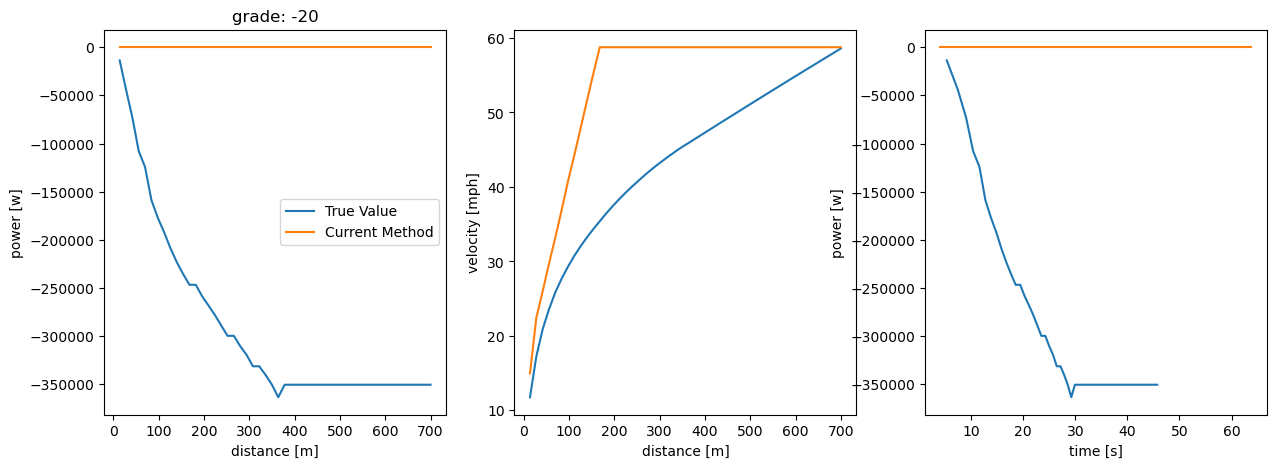

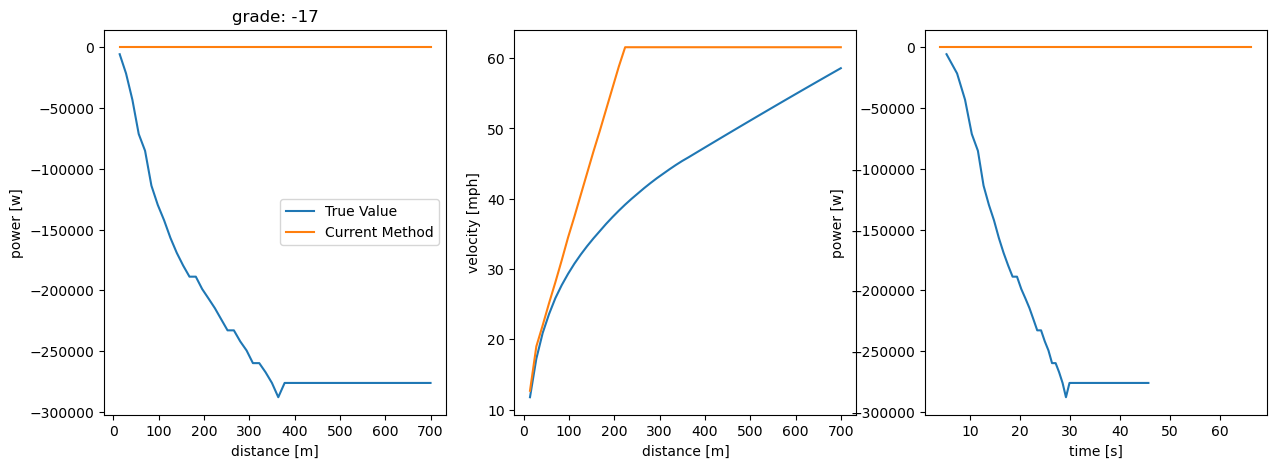

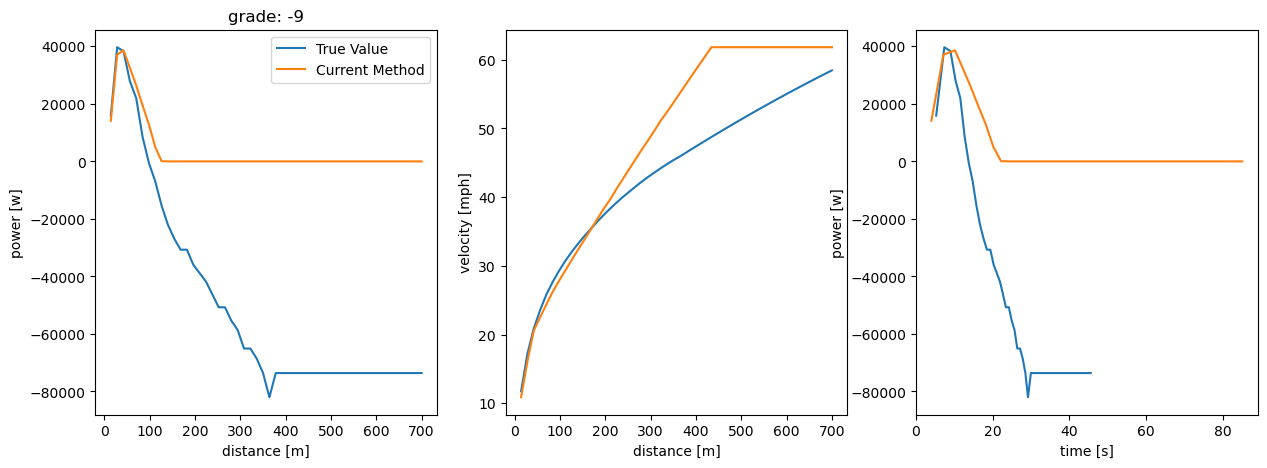

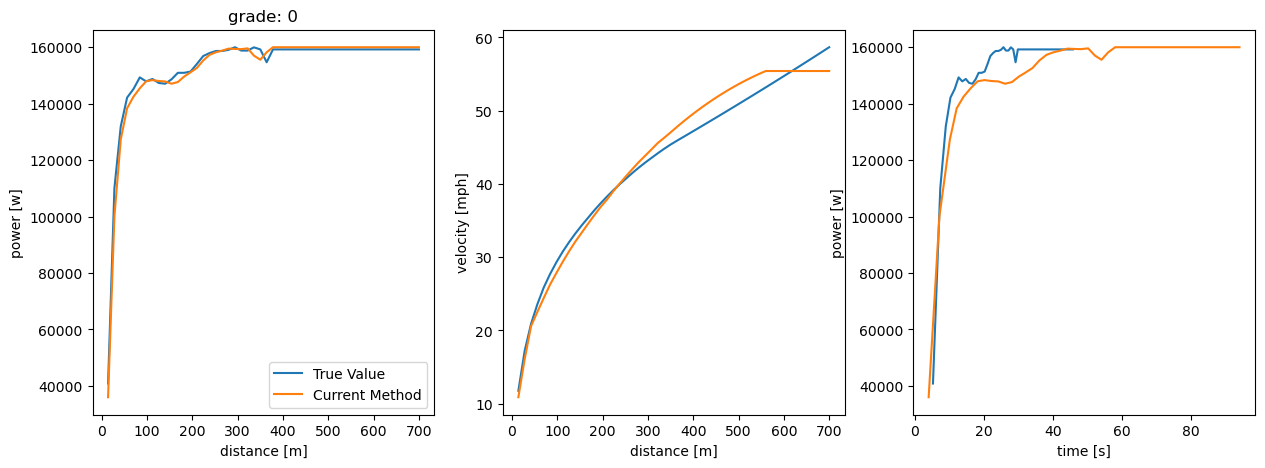

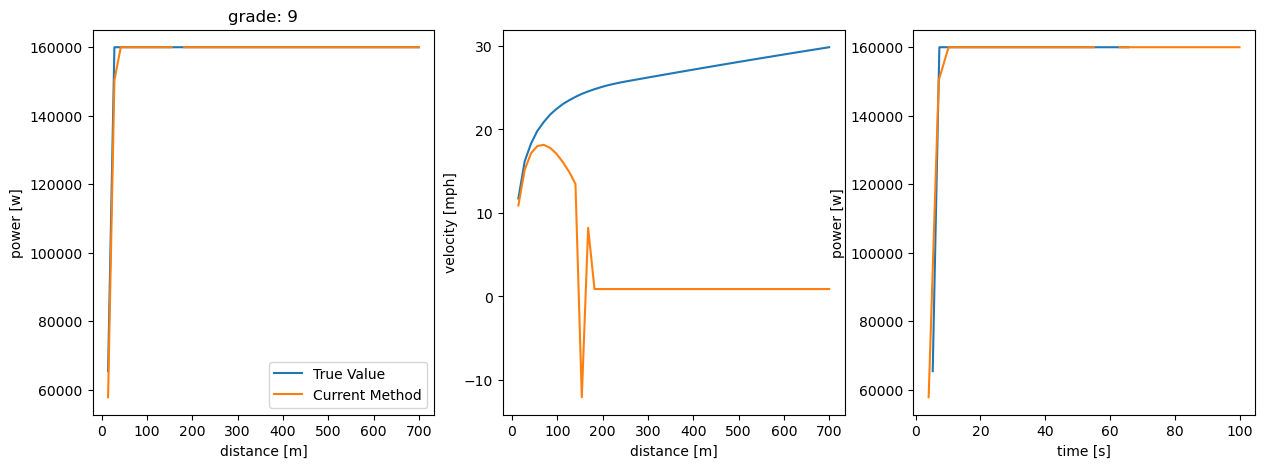

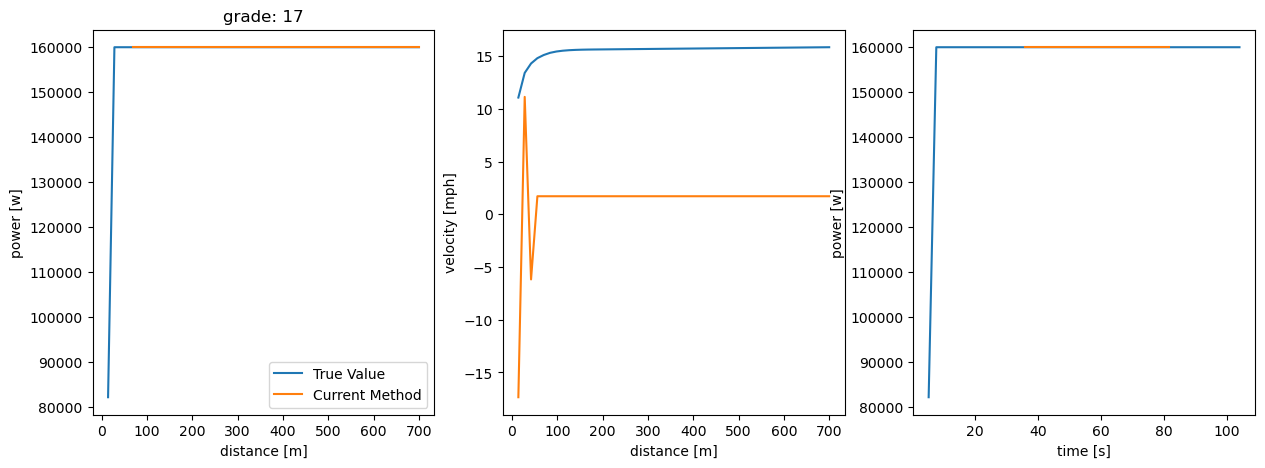

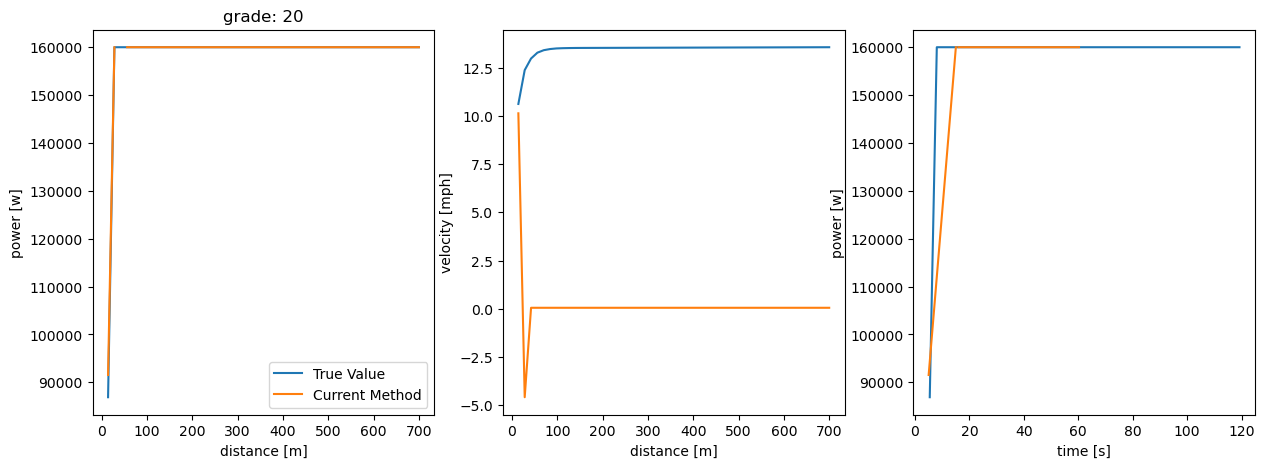

In [73]:
mass = 13041

# Compare time and power differences between straight-shots and stepwise-----
print("Comparing dt and power calculations and final velocity vs actual:")
print()

for grade in grade_array:
    dist = 14
    v = 0
    p_list = []
    t_list = []
    v_list = []
    t_t = 0
    for i in range(50):
        p, t, v = accelerate_v5(mass, grade, v, dist)
        t_t += t
        p_list.append(p)
        t_list.append(t_t)
        v_list.append(v)
        
        
    ext_a = (.01)*9.81*np.cos(np.arctan(grade/100)) + 9.81*np.sin(np.arctan(grade/100))
    sample_bus = BusModel(a_prof)
    p_list_2 = []
    t_list_2 = []
    v_list_2 = []
    t_t = 0
    for i in range(50):
        p, t = sample_bus.accelerate_v4(dist, ext_a)
        t_t += t
        p_list_2.append(p)
        t_list_2.append(t_t)
        v_list_2.append(sample_bus.velocity())
    #print('grade: {}'.format(grade))
    fig, ax = plt.subplots(1, 3, figsize = (15, 5))
    dist = np.arange(14*1, 14*51, 14)
    ax[0].set_title('grade: {}'.format(grade))
    ax[0].plot(dist, p_list)
    ax[0].plot(dist, p_list_2)
    ax[0].set_xlabel('distance [m]')
    ax[0].set_ylabel('power [w]')
    ax[1].plot(dist, np.asarray(v_list)*2.236)
    ax[1].plot(dist, np.asarray(v_list_2)*2.236)
    ax[1].set_xlabel('distance [m]')
    ax[1].set_ylabel('velocity [mph]')
    ax[2].plot(t_list, p_list)
    ax[2].plot(t_list_2, p_list_2)
    ax[2].set_xlabel('time [s]')
    ax[2].set_ylabel('power [w]')
    ax[0].legend(['True Value','Current Method'])
    plt.show()


    

35995.68391097069 4.036697248
100059.37429736563 3.119266055
127338.63312884963 3.0275229360000004
138353.14173713283 1.9724770639999996
---
17661.94836139759 1.4867915163580487
17661.94836139759 1.4867915163580487
17661.94836139759 1.4867915163580487
---
-152500.7518506456 1.6914905996832827
-99578.14619970249 2.590463852205864
-93319.85581222159 2.764187599250633


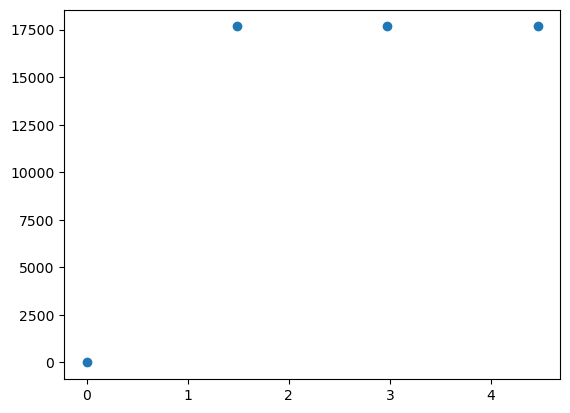

In [41]:
sample_bus = BusModel(a_prof)
vees = []
dists = []
powe = [0]
tee = [0]
v=0
d = 0
while (v < 11.176 - 11.176/10):
    p, t = sample_bus.accelerate_v4(14.985, .0981)
    v = sample_bus.velocity()
    vees.append(v)
    d+=14.985
    dists.append(d)
    print(p, t)
    
    
print("---")
dist = 0
while (dist < 40):
    p, t = sample_bus.maintain_v4(14.985, .0981)
    print(p, t)
    dist += 14.985
    v = sample_bus.velocity()
    dists.append(dist+d)
    vees.append(v)
    powe.append(p)
    tee.append(tee[-1]+t)
    
print("---")
while (v > 0.05):
    p, t = sample_bus.brake_v3(14.985, .8, .0981)
    v = sample_bus.velocity()
    vees.append(v)
    d+=14.985
    dists.append(d)
    print(p, t)

fig, ax = plt.subplots(1, 1)
ax.scatter(tee, powe)


In [14]:
# Load the csv of the rider difference
# sorted_riders_diff = (pd.read_csv('rider_diff_22.csv', index_col=False, header=0))['0']
default_bus = BusModel(a_prof)
# generate a tripDynamics object, using the route map, bus, and ridership
# changes
pd.set_option('display.max_rows', None)
test_trip_dynamic = td.TripDynamics(smoothed_test_map,
                                    default_bus,
                                    sorted_riders_diff)

# Run the trip
test_trip = test_trip_dynamic.bus_trip()

In [15]:
#test_trip[(test_trip['cumulative_distance[km]']> 2.5) & (test_trip['cumulative_distance[km]']< 3)]
#test_trip[test_trip.index > 1590]

Total Energy Used: 120.74174145636893 kWh
Heuristic: 0.25004094630707213 mi/kwh


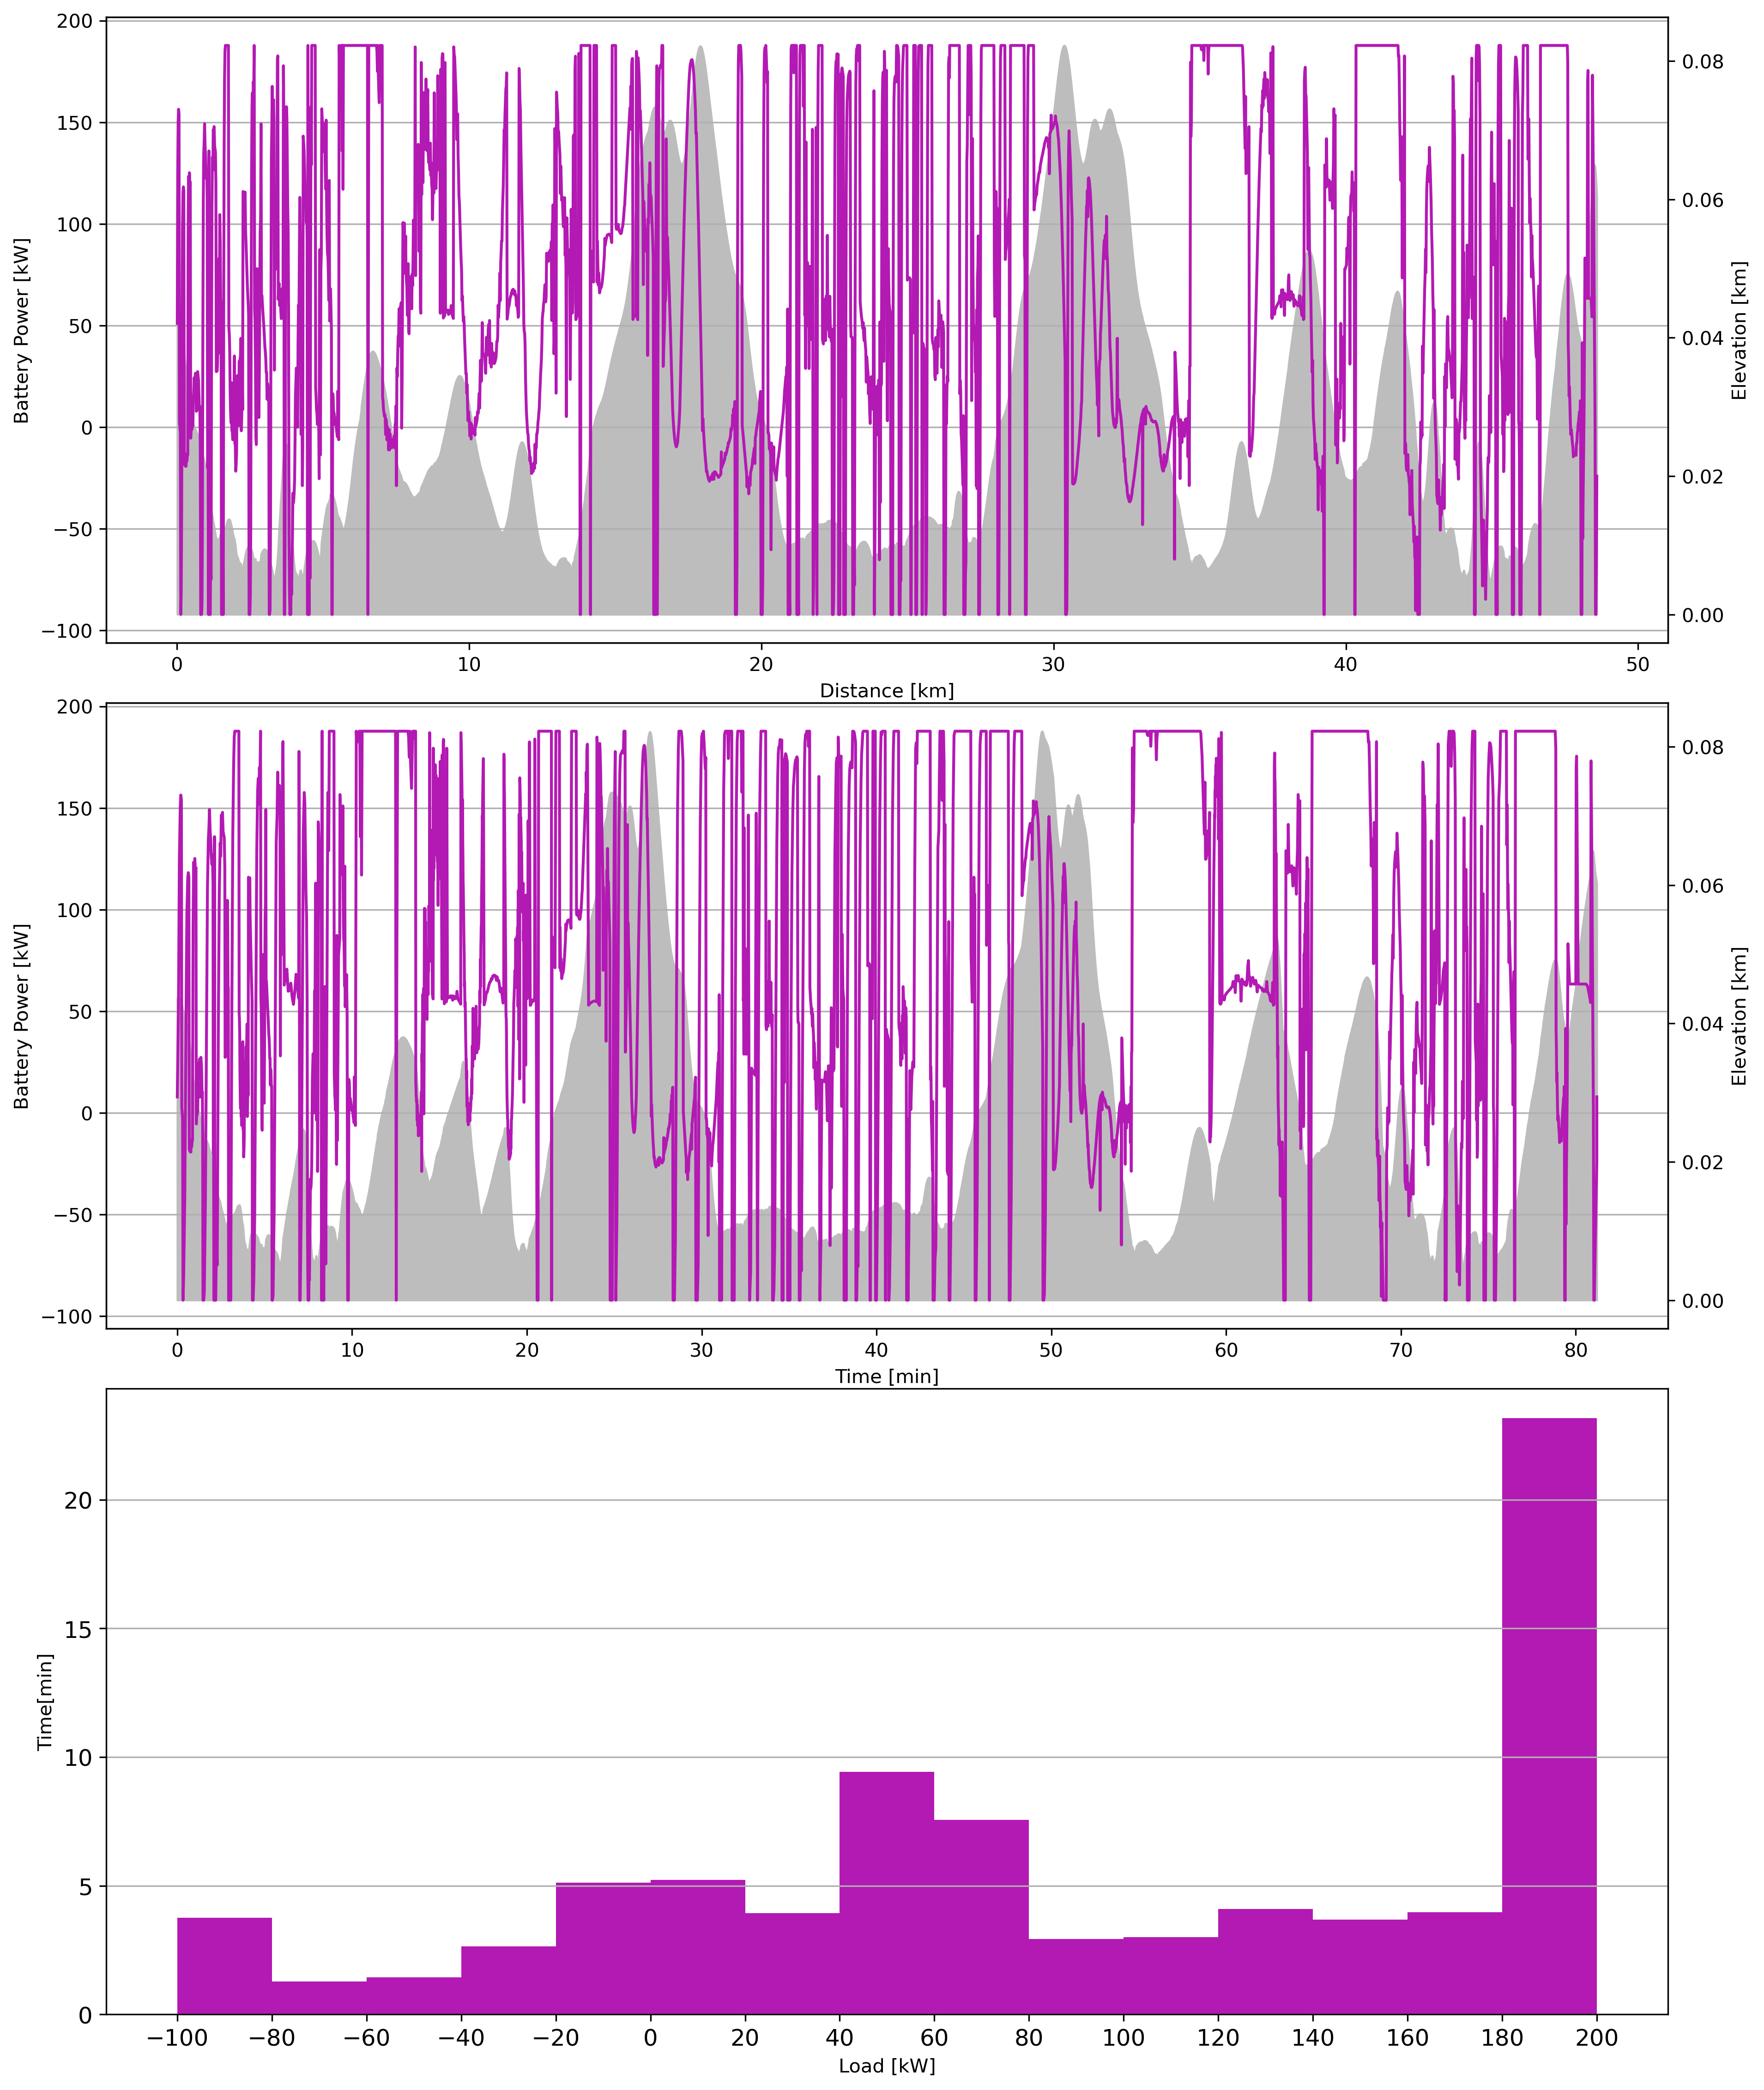

In [15]:
# plot the ESS load:
# get the ESS profile of the trip:
ess_prof = test_trip_dynamic.generate_ESS_profile()

# Convert the ess profile to kilowatts:
ess_prof = ess_prof/1000

raw_prof = test_trip['power_needed[W]']/1000

# get the distance series:
distance = test_trip['cumulative_distance[km]']

# get the elevation series:
elev = test_trip['elevation[km]']

# get the time change series:
delta_tees = test_trip['time_change[s]']

# get running time series
time = test_trip['elapsed_time[s]']

# convert time change to minutes
delta_tees = delta_tees/60
time = time/60

# generate figure
fig, ax = plt.subplots(3, 1, figsize = (12, 15), dpi=300)
plt.tight_layout()



# Load profile (distance based)
#ax[0].plot(distance, test_trip['vel.[m/s]']*2.236, c='#b319b3')
#ax[0].plot(distance, test_trip["vel.[m/s]"], c='yellow')
ax[0].plot(distance, ess_prof, c='#b319b3')
ax[0].set_xlabel("Distance [km]")
ax[0].set_ylabel("Battery Power [kW]")
#ax[0].set_ylabel("Velocity [m/s]")
ax[0].set_zorder(1)
ax[0].set_facecolor('none')
ax[0].grid(axis='y')
#ax[0].set_xlim(15.8, 16.4)
#ax[0].set_xlim(37.5,40)
#ax[0].set_xlim(23.68, 24)
#ax[0].set_xlim(7,8)
#ax[0].set_ylim(0, 15)
#ax[0].plot(distance, test_trip["vel.[m/s]"], c='#b319b3')
#ax[0].plot(distance, test_trip['speed_limit[km/s]']*1000)
#ax[0].plot(distance, test_trip['speed_limit[km/s]']*1000 + test_trip['speed_limit[km/s]']*1000/20, c='tab:orange')
#ax[0].plot(distance, test_trip['speed_limit[km/s]']*1000 - test_trip['speed_limit[km/s]']*1000/20, c='tab:orange')

# Elevation
ax_0_1 = ax[0].twinx()
ax_0_1.fill_between(distance, elev, color = '#BDBDBD')
ax_0_1.set_ylabel("Elevation [km]")
ax_0_1.set_zorder(0)

#ax_0_1.scatter(distance, test_trip['is_stop']*elev, c="tab:green")
#ax_0_1.scatter(distance, test_trip['is_signal']*elev, c="tab:red")

# Load profile (time based)
ax[1].plot(time, ess_prof, c='#b319b3')
ax[1].set_xlabel("Time [min]")
ax[1].set_ylabel("Battery Power [kW]")
ax[1].set_zorder(1)
ax[1].set_facecolor('none')
ax[1].grid(axis='y')

# Elevation
ax_1_1 = ax[1].twinx()
ax_1_1.fill_between(time, elev, color = '#BDBDBD')
ax_1_1.set_ylabel("Elevation [km]")
ax_1_1.set_zorder(0)


# Power Bin Histogram
bins = [-100, -80, -60, -40, -20, 0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200]
ax[2].hist(ess_prof, color='#b319b3', bins=bins, weights=delta_tees)
ax[2].set_ylabel('Time[min]')
ax[2].set_xlabel('Load [kW]')
ax[2].tick_params(labelsize=12)
ax[2].set_xticks(bins)
ax[2].grid(axis='y')

# Create a column for the ess profile
dts = test_trip['time_change[s]']
net_energy = (ess_prof*dts).sum()/3600 # kWh
print("Total Energy Used: {} kWh".format(net_energy))
print("Heuristic: {} mi/kwh".format(list(test_trip['cumulative_distance[km]'])[-2]*0.6213712 / net_energy))
# control drag coefficient
# Control road drag
# plot each term, what value
# Elevation
# ffc of the parameters for the bus to deduce which is the issue
# reduce passenger mass/INCREASE mass

# Is there a straight line where this happens?
# is it wiggling in slope causing instability?
# look at linear stability theory

# different slopes, different enveopes of distance and uncertainty, plot stable, unstable and find stable and unstable
# damping factor via forward differencing, remove oscillation

# Standard EV on ld veh. 4mi p kwh
# Big tesla 3, small american 4, mitsubishi 6.25

# gut check should be kwh/mi

# Elevation from google API?


# plot estimated power/velocity vs true power and velocity


mean load: 48.09829653626118
    stdev: 108.50581586303556


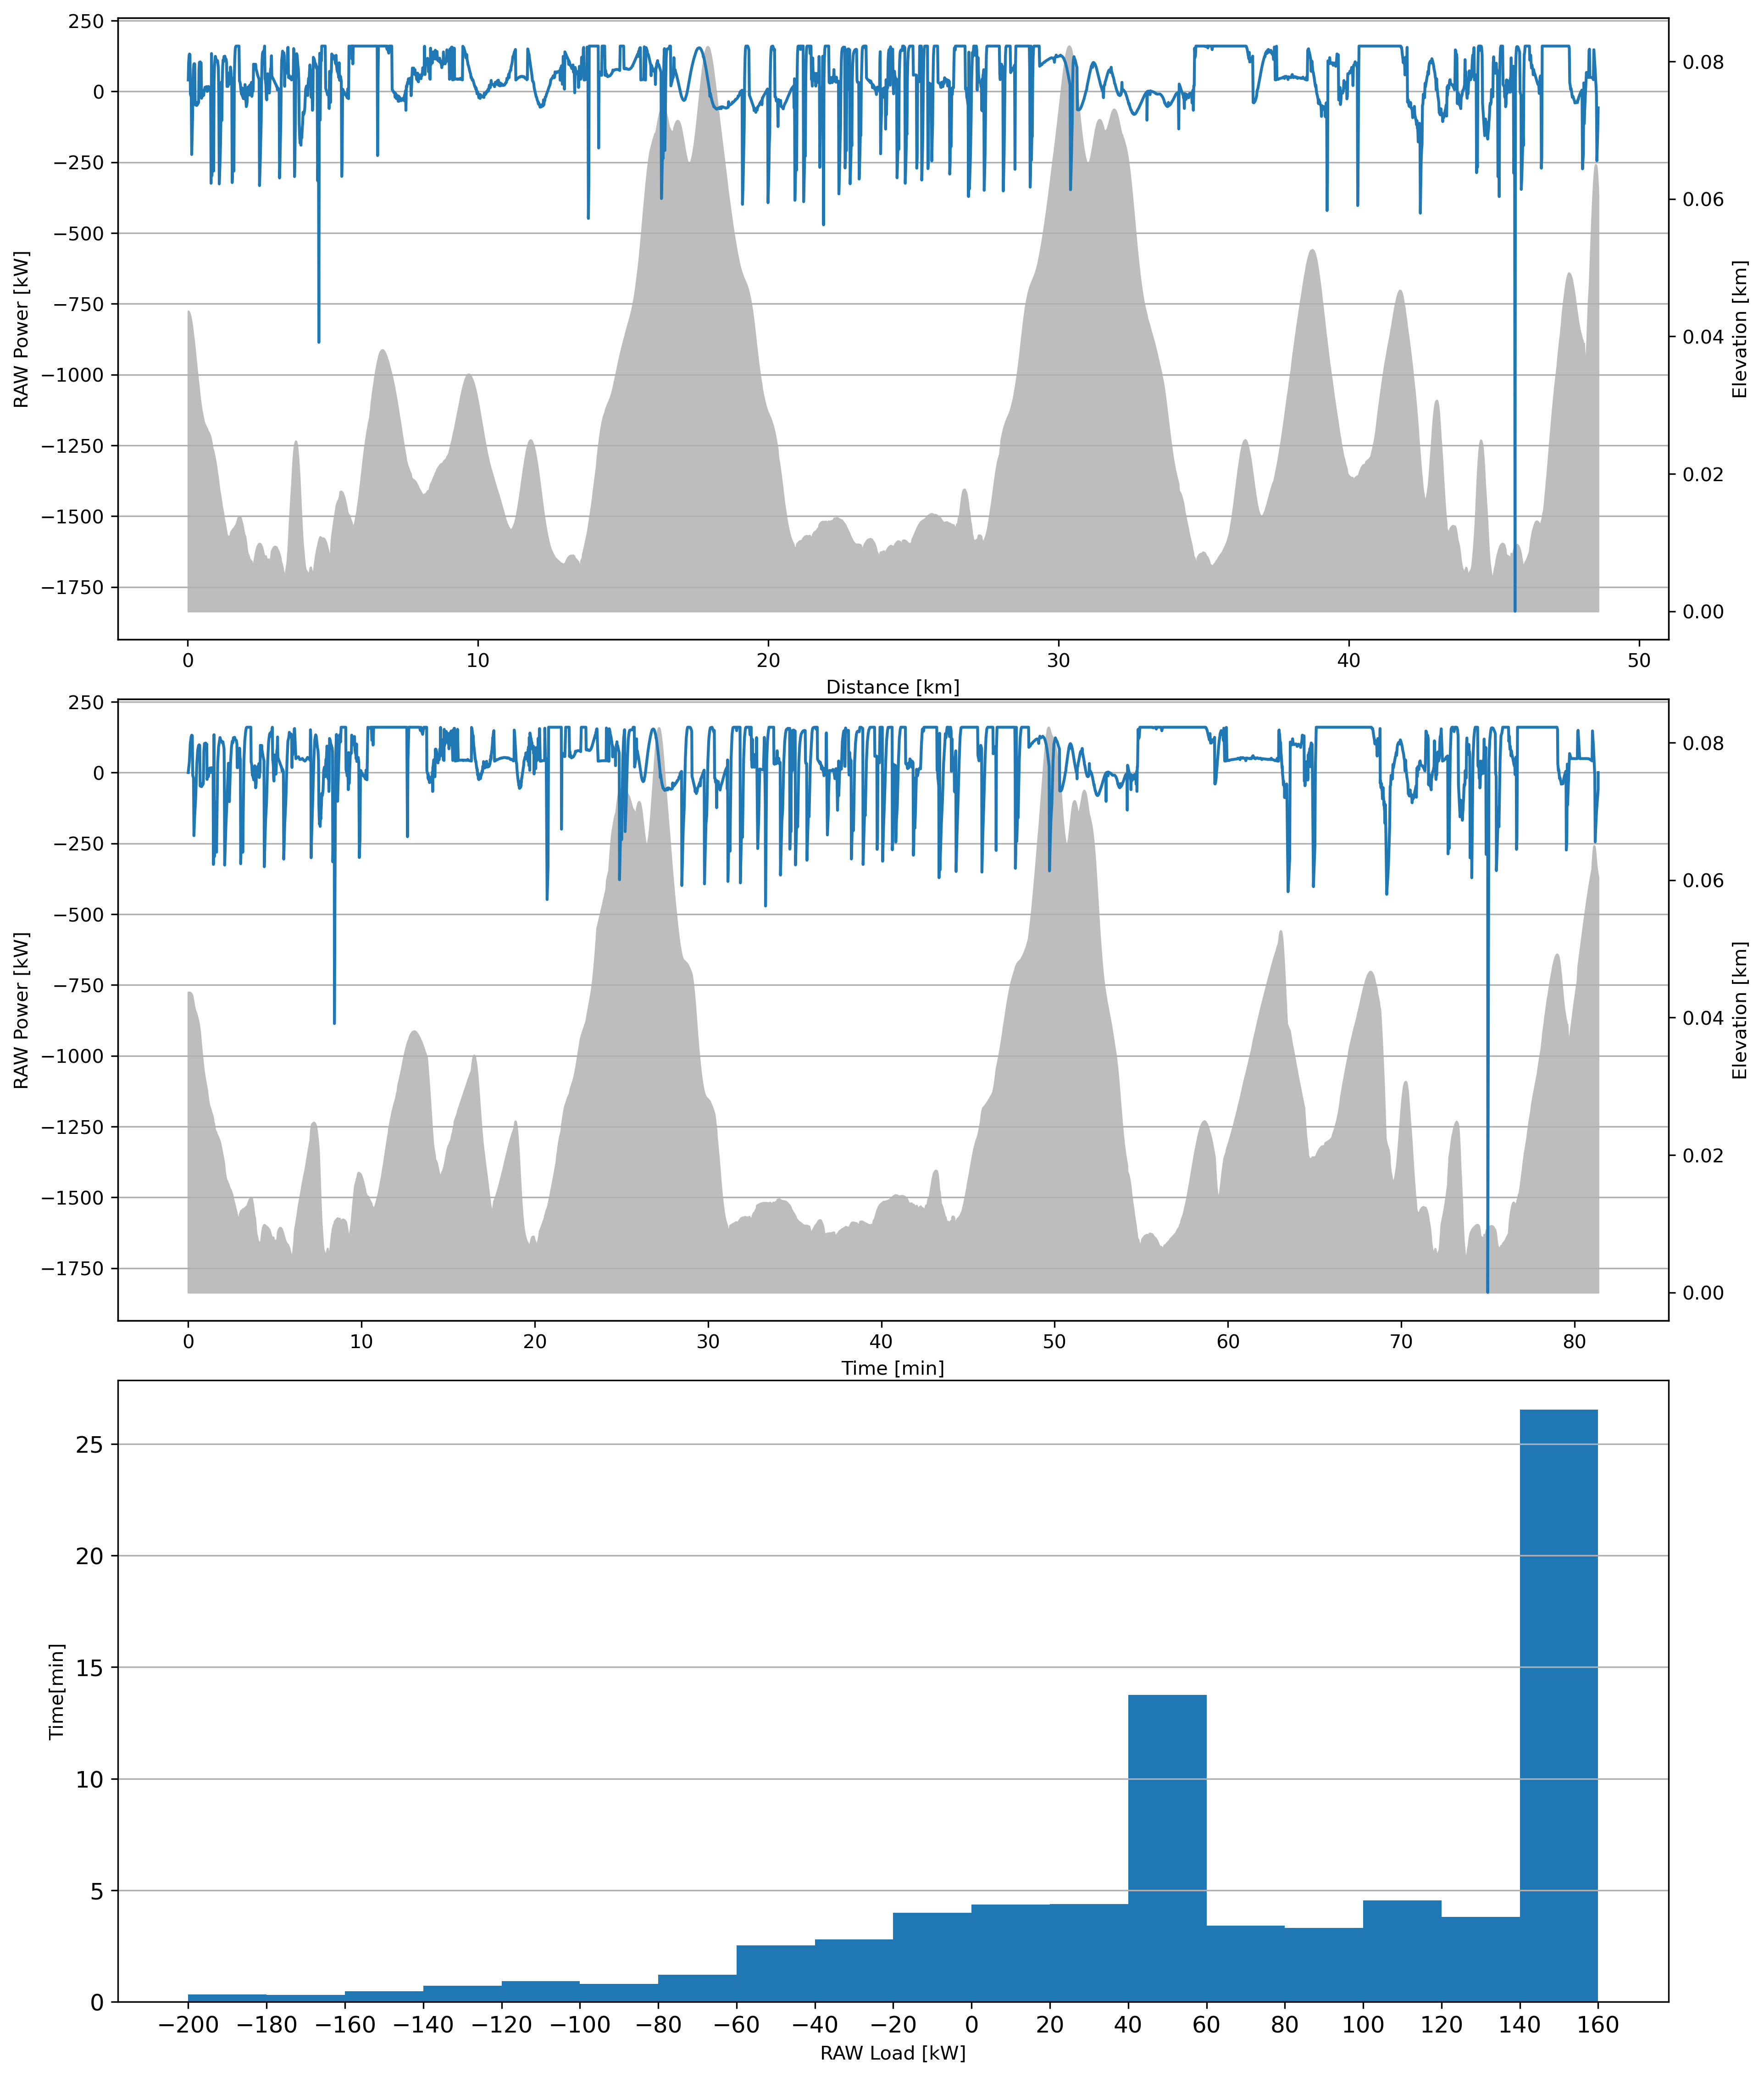

In [50]:
# Plot the raw load

# Time in hours * each bin BC we want to know kwH, 
# generate figure
fig, ax = plt.subplots(3, 1, figsize = (12, 15), dpi=300)
plt.tight_layout()

# Load profile (distance based)
ax[0].plot(distance, raw_prof, c='tab:blue')
ax[0].set_xlabel("Distance [km]")
ax[0].set_ylabel("RAW Power [kW]")
ax[0].set_zorder(1)
ax[0].set_facecolor('none')
ax[0].grid(axis='y')


# Elevation
ax_0_1 = ax[0].twinx()
ax_0_1.fill_between(distance, elev, color = '#BDBDBD')
ax_0_1.set_ylabel("Elevation [km]")
ax_0_1.set_zorder(0)

# Load profile (time based)
ax[1].plot(time, raw_prof, c='tab:blue')
ax[1].set_xlabel("Time [min]")
ax[1].set_ylabel("RAW Power [kW]")
ax[1].set_zorder(1)
ax[1].set_facecolor('none')
ax[1].grid(axis='y')

# Elevation
ax_1_1 = ax[1].twinx()
ax_1_1.fill_between(time, elev, color = '#BDBDBD')
ax_1_1.set_ylabel("Elevation [km]")
ax_1_1.set_zorder(0)


# Power Bin Histogram
bins = [-200,-180,-160,-140,-120,-100, -80, -60, -40, -20, 0, 20, 40, 60, 80, 100, 120, 140, 160]
ax[2].hist(raw_prof, color='tab:blue', bins=bins, weights=delta_tees)
ax[2].set_ylabel('Time[min]')
ax[2].set_xlabel('RAW Load [kW]')
ax[2].tick_params(labelsize=12)
ax[2].set_xticks(bins)
ax[2].grid(axis='y')

print('mean load: {}'.format(raw_prof.mean()))
print('    stdev: {}'.format(raw_prof.std()))